In [16]:
# import statements
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [17]:
# Loading data

# Fake data
articles = np.asarray([
    ["Donald Trump buys a dog", "Donald Trump recently was found buying a dog"],
    ["President Trump gets a corgie", "The White House welcomes a new furry friend, and its name is Evan!"],
    ["U.S. Presidential Paws", "You won't believe the new dog that Donald and the fam just got!"],
    ["Biden sells his old car", "President Biden just announced that he is selling is '96 Civic"],
    ["President Biden to sell car", "Biden announced via Twitter that he will indeed be selling his car"],
    ["Biden getting that car cash", "Biden is about to cash out once he sells that junker civic!"]
])

data = utils.toframe(utils.files)

,article_id,title,abstract,author,source,time_stamp,link,query
0,-6147527364334339038,COVID-19 Update: The COVID-19 Pfizer Vaccine,What is the safety and efficacy of BNT162b2 va...,rebelem.com,2020-12-15T15:54:49.000000Z,https://rebelem.com/covid-19-update-the-covid-...,['health'],covid
1,-256664617741646369,Some Covid Links,Tweetâ€œIf someone who has tested positive for...,cafehayek.com,2020-12-14T11:26:45.000000Z,https://cafehayek.com/2020/12/some-covid-links...,"['business', 'politics']",covid
2,8925806711739426900,Statement â€“ Update on COVID-19: WHO/Europe c...,"25 February 2021, Dr Hans Henri P. Kluge, WHO ...",euro.who.int,2021-02-25T12:36:49.000000Z,https://www.euro.who.int/en/media-centre/secti...,"['health', 'general']",covid
3,1042132597465427526,Brazilian Covid variant: Is the Brazilian Covi...,BRAZIL has joined the UK and South Africa in d...,express.co.uk,2021-01-15T17:22:01.000000Z,https://www.express.co.uk/life-style/health/13...,['health'],covid
4,8160041768289156967,Covid cafes,Iâ€™m puzzled that during the pandemic so few ...,lesswrong.com,2021-02-03T08:20:14.000000Z,https://www.lesswrong.com/posts/63zMw9Hx4HFfBv...,['science'],covid
...,...,...,...,...,...,...,...,...
4148,-7016152509062198523,Copper Won’t Save You From Coronavirus,Pandemic fears have created interest in metall...,By Katherine J. Wu,The New York Times,2020-06-19T16:12:18+0000,https://www.nytimes.com/article/copper-coronav...,"""Johnson"" OR ""Johnson & Johnson"" OR ""Johnson a..."
4149,-916519868558019586,PG&E Reveals New C.E.O. and a Revamped Board o...,"Bill Johnson, most recently the head of the Te...","By Ivan Penn, Peter Eavis and Lauren Hepler",The New York Times,2019-04-04T01:28:55+0000,https://www.nytimes.com/2019/04/03/business/pa...,"""Johnson"" OR ""Johnson & Johnson"" OR ""Johnson a..."
4150,5290822117476702205,Brexit Done? Not So Fast. Britain and E.U. Ent...,Three days after the U.K.’s formal withdrawal ...,By Stephen Castle and Matina Stevis-Gridneff,The New York Times,2020-02-03T20:58:41+0000,https://www.nytimes.com/2020/02/03/world/europ...,"""Johnson"" OR ""Johnson & Johnson"" OR ""Johnson a..."
4151,8549583551398279262,Chicago Officer Was Killed by Man Seeking to S...,A suspect in the killing of the off-duty offic...,By Sandra E. Garcia,The New York Times,2019-03-26T17:21:16+0000,https://www.nytimes.com/2019/03/26/us/chicago-...,"""Johnson"" OR ""Johnson & Johnson"" OR ""Johnson a..."


In [ ]:
# Vectorizing 
roberta = SentenceTransformer('stsb-roberta-base')
a = np.asarray([x + ': ' + y for x,y in zip(data['title'], data['abstract'])])
v = utils.encode(a[0:100], roberta)

In [ ]:
# Retrieving related articles 

In [ ]:
# Creating the graph
import networkx as nx

G = nx.Graph()

In [ ]:
G.clear()
for root, v0 in zip(data['title'], v):
    for comp, v1 in zip(data['title'], v):
        if utils.doc_sim(v0,v1) > .5:
            G.add_edge(root, comp, weight=utils.doc_sim(v0,v1))

In [ ]:
nx.draw(G)

In [ ]:
from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):

    centrality = betweenness(G, weight="weight")

    return max(centrality, key=centrality.get)

comp = community.girvan_newman(G, most_valuable_edge=most_central_edge)

communities =tuple(sorted(c) for c in next(comp))

In [ ]:
# Extracting full articles from communities
cdf = []
for com in communities:
    df = pd.DataFrame()
    for art in com:
        x = data.loc[data['title'] == art]
        df = df.append(x)
    cdf.append(df)

In [13]:
# Reducing each community down to an article 
min_coms = [] 
for com in cdf:
    min_time = min(com['time_stamp'])
    df = pd.DataFrame()
    df = df.append(com.loc[com['time_stamp'] == min_time])
    min_coms.append(df)

In [14]:
el = nx.Graph()
el.clear()

# Generating Lv and Huang graph 
lv = sorted([(x,list(x['time_stamp'])) for x in min_coms], key = lambda x: x[1])
lv = [x[0] for x in lv]
for i in range(1, len(lv)):
    el.add_edge(str(lv[i-1]['title']), str(lv[i]['title']))

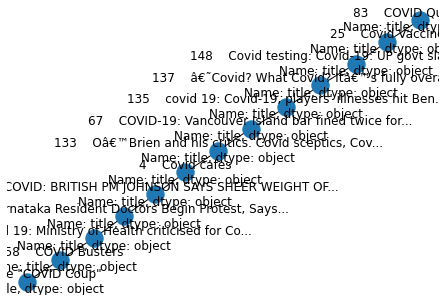

In [15]:
# Drawing the graph 
%matplotlib inline
nx.draw_kamada_kawai(el, with_labels=True)

In [ ]:
# Generating NewsChain event line 

# Defining similarity between sub-events 
# Similarity = avg_pairwise_eos 
# Rules for drawing edge, if sim > theta, draw directed edge based on min time 
el.clear()
